In [1]:
import torch
import torch.nn as nn

import numpy as np
from layers import GraphSAGELayer

from train import train_ppi, evaluate_ppi

from copy import deepcopy
import pandas as pd


from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader


%load_ext autoreload
%autoreload 2

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)



Device:  cuda


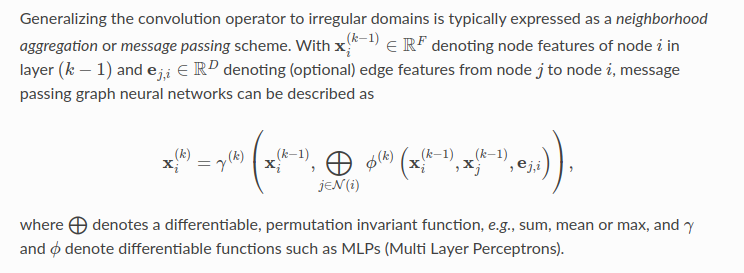

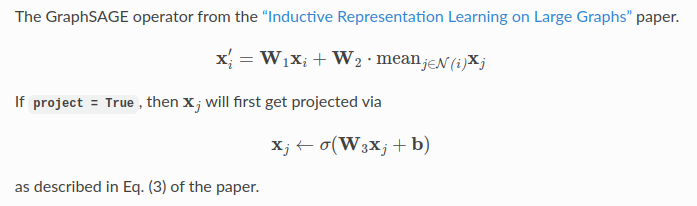

In [2]:
# Load the PPI dataset
path = '/tmp/PPI'
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')



Extracting /tmp/PPI/ppi.zip
Processing...
Done!


In [3]:
# Create a DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [4]:
class GraphSAGE(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_layers):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GraphSAGELayer(input_features, hidden_features, aggr='mean', activation=True))
        for _ in range(num_layers - 2):
            self.layers.append(GraphSAGELayer(hidden_features, hidden_features, aggr='mean', activation=True))
        self.layers.append(GraphSAGELayer(hidden_features, output_features, aggr='mean', activation=False))
        
    def forward(self, x, edge_index):
        for layer in self.layers:
            x = layer.propagate(x, edge_index)
        return x
    


In [ ]:

### Max number of epochs
max_epochs = 300

### Number of features
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]
hidden_size = 256

### DEFINE THE MODEL
basic_model = GraphSAGE(n_features, hidden_size, n_classes, num_layers=2).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.0001)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train_ppi(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_loader,
    val_loader,
)

# evaluate the model on the test set
test_score = evaluate_ppi(basic_model, device, test_loader)
print(f"Test F1-score: {test_score}")

# Model Assesment and Model Selection

In [ ]:
# gather all data in one dataset (train/val/test)   
all_data = train_dataset + val_dataset + test_dataset
all_loader = DataLoader(all_data, batch_size=2, shuffle=False)

### Max number of epochs
max_epochs = 300

### Number of features
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)


# for k in range(1, 10): perform K fold seperation of the data into test and train_out
K = 12
best_score = 0
best_model = None
best_hyperparameters = None
results = pd.DataFrame(columns=['K', 'valid_score', 'test_score', 'lr', 'num_layers', 'hidden_size'])
all_data = train_dataset + val_dataset + test_dataset
for k in range(K):
    print(f"K-Fold: {k+1}/{K}")
    # split the data into train and test
    n = len(all_data)//K 
    test_range_index = np.arange(k*n, (k+1)*n)
    # all the rest for train
    train_range_index = np.setdiff1d(np.arange(len(all_data)), test_range_index)
    train_out = torch.utils.data.Subset(all_data, train_range_index)
    test = torch.utils.data.Subset(all_data, test_range_index)

    # randomly choose 20% of the train_out data to be the validation set
    n = len(train_out)//5
    val_range_index = np.random.choice(len(train_out), n, replace=False)
    val = torch.utils.data.Subset(train_out, val_range_index)
    train_in = torch.utils.data.Subset(train_out, np.setdiff1d(np.arange(len(train_out)), val_range_index))

    

    # create the dataloader
    train_in_loader = DataLoader(train_in, batch_size=2, shuffle=True)
    val_loader = DataLoader(val, batch_size=2, shuffle=False)
    test_loader = DataLoader(test, batch_size=2, shuffle=False)

    # define hyperparameters grid
    hyperparameters = {
        'lr': [0.01],
        'num_layers': [2],
        'hidden_size': [256, 512, 1024]
    }

    best_score = 0
    for lr in hyperparameters['lr']:
        for num_layers in hyperparameters['num_layers']:
            for hidden_size in hyperparameters['hidden_size']:
                print(f"lr: {lr}, num_layers: {num_layers}, hidden_size: {hidden_size}")
                ### DEFINE THE MODEL
                basic_model = GraphSAGE(n_features, hidden_size, n_classes, num_layers).to(device)

                ### DEFINE LOSS FUNCTION
                loss_fcn = nn.BCEWithLogitsLoss()

                ### DEFINE OPTIMIZER
                optimizer = torch.optim.Adam(basic_model.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.0001)

                ### TRAIN THE MODEL
                epoch_list, basic_model_scores = train_ppi(
                    basic_model,
                    loss_fcn,
                    device,
                    optimizer,
                    max_epochs,
                    train_in_loader,
                    val_loader,
                    save_best=True
                )

                # evaluate the model on the test set
                valid_score = evaluate_ppi(basic_model, device, val_loader)
                print(f"Valid F1-score: {valid_score}")

                # save the best model
                if valid_score > best_score:
                    best_score = valid_score
                    del best_model
                    best_model = deepcopy(basic_model)
                    best_hyperparameters = {
                        'lr': lr,
                        'num_layers': num_layers,
                        'hidden_size': hidden_size
                    }
                results.loc[len(results.index)] = [k, valid_score, 0, lr, num_layers, hidden_size]

                del basic_model
                del optimizer
                del scheduler
                torch.cuda.empty_cache()
                

    # evaluate the best model on the test set
    test_score = evaluate_ppi(best_model, device, test_loader)
    print(f"Test F1-score: {test_score}")

    # save the results in dataframe
    results.loc[len(results.index)] = [k, best_score, test_score, best_hyperparameters['lr'], best_hyperparameters['num_layers'], best_hyperparameters['hidden_size']]

# save the results in a csv file
results.to_csv('sage_results.csv', index=False)

In [15]:
results[results['test_score']>0.].test_score.mean()

0.9258662229112695

In [16]:
results[results['test_score']>0.].test_score.std()

0.03848616948732571

# Pytorch VS Ours

In [10]:
from torch_geometric.nn.conv import SAGEConv

class PytorchGraphSAGE(nn.Module):
    def __init__(self, input_features, hidden_features, output_features, num_layers):
        super(PytorchGraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(input_features, hidden_features))
        for _ in range(num_layers - 2):
            self.layers.append(SAGEConv(hidden_features, hidden_features, project=False))
        self.layers.append(SAGEConv(hidden_features, output_features, project=False))
        self.relu = nn.ReLU()
    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index)
            x = self.relu(x)
        x = self.layers[-1](x, edge_index)
        return x



In [15]:
def train_pipeline(model, train_in_loader, val_loader, lr, num_layers, hidden_size, model_name, results, max_epochs=300):
    loss_fcn = nn.BCEWithLogitsLoss()
    best_model = None
    best_score = 0

    ### DEFINE OPTIMIZER
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=0.0001)
    ### TRAIN THE MODEL
    _, _ = train_ppi(
        model,
        loss_fcn,
        device,
        optimizer,
        max_epochs,
        train_in_loader,
        val_loader,
        save_best=True
    )
        # evaluate the model on the test set
    valid_score = evaluate_ppi(model, device, val_loader)
    print(f"Valid F1-score: {valid_score}")

    # save the best model
    if valid_score > best_score:
        best_score = valid_score
        del best_model
        best_model = deepcopy(model)
    results.loc[len(results.index)] = [k, valid_score, 0, lr, num_layers, hidden_size, model_name]
    del model
    del optimizer
    del scheduler
    torch.cuda.empty_cache()
    return results, best_model

In [16]:
# gather all data in one dataset (train/val/test)   
all_data = train_dataset + val_dataset + test_dataset
all_loader = DataLoader(all_data, batch_size=2, shuffle=False)

### Max number of epochs
max_epochs = 300

### Number of features
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)


# for k in range(1, 10): perform K fold seperation of the data into test and train_out
K = 12
best_score = 0
best_hyperparameters = None
results = pd.DataFrame(columns=['K', 'valid_score', 'test_score', 'lr', 'num_layers', 'hidden_size', 'model'])
all_data = train_dataset + val_dataset + test_dataset
for k in range(K):
    print(f"K-Fold: {k+1}/{K}")
    # split the data into train and test
    n = len(all_data)//K 
    test_range_index = np.arange(k*n, (k+1)*n)
    # all the rest for train
    train_range_index = np.setdiff1d(np.arange(len(all_data)), test_range_index)
    train_out = torch.utils.data.Subset(all_data, train_range_index)
    test = torch.utils.data.Subset(all_data, test_range_index)

    # randomly choose 20% of the train_out data to be the validation set
    n = len(train_out)//5
    val_range_index = np.random.choice(len(train_out), n, replace=False)
    val = torch.utils.data.Subset(train_out, val_range_index)
    train_in = torch.utils.data.Subset(train_out, np.setdiff1d(np.arange(len(train_out)), val_range_index))

    

    # create the dataloader
    train_in_loader = DataLoader(train_in, batch_size=2, shuffle=True)
    val_loader = DataLoader(val, batch_size=2, shuffle=False)
    test_loader = DataLoader(test, batch_size=2, shuffle=False)

    # define hyperparameters grid
    lr = 0.01
    num_layers = 2
    hidden_size = 512


    ### DEFINE THE MODEL
    graphsage = GraphSAGE(n_features, hidden_size, n_classes, num_layers).to(device)
    pytorch_graphsage = PytorchGraphSAGE(n_features, hidden_size, n_classes, num_layers).to(device)
    ### DEFINE LOSS FUNCTION

    results, best_model = train_pipeline(graphsage, train_in_loader, val_loader, lr, num_layers, hidden_size, 'graphsage', results)
    results, pytorch_best_model = train_pipeline(pytorch_graphsage, train_in_loader, val_loader, lr, num_layers, hidden_size, 'pytorch_graphsage', results)



    # evaluate the best model on the test set
    test_score = evaluate_ppi(best_model, device, test_loader)
    print(f"Ours: Test F1-score: {test_score}")
    # save the results in dataframe
    results.loc[len(results.index)] = [k, best_score, test_score, lr, num_layers, hidden_size, 'graphsage']

    test_score = evaluate_ppi(pytorch_best_model, device, test_loader)
    print(f"Pytorch: Test F1-score: {test_score}")
    # save the results in dataframe
    results.loc[len(results.index)] = [k, best_score, test_score, lr, num_layers, hidden_size, 'pytorch_graphsage']

# save the results in a csv file
results.to_csv('pytorch_vs_ours.csv', index=False)


Device:  cuda
K-Fold: 1/12


100%|██████████| 300/300 [02:50<00:00,  1.76epoch/s, f1=0.93, loss=0.0638] 


Best model loaded
Valid F1-score: 0.9309550678561935


100%|██████████| 300/300 [01:56<00:00,  2.58epoch/s, f1=0.93, loss=0.0629] 


Best model loaded
Valid F1-score: 0.9301215973816284
Ours: Test F1-score: 0.8543694136907469
Pytorch: Test F1-score: 0.8550426783790503
K-Fold: 2/12


100%|██████████| 300/300 [03:12<00:00,  1.55epoch/s, f1=0.91, loss=0.0801] 


Best model loaded
Valid F1-score: 0.9198156222575502


100%|██████████| 300/300 [02:13<00:00,  2.24epoch/s, f1=0.916, loss=0.075] 


Best model loaded
Valid F1-score: 0.919738265879013
Ours: Test F1-score: 0.959871420528961
Pytorch: Test F1-score: 0.9601654674163195
K-Fold: 3/12


100%|██████████| 300/300 [03:02<00:00,  1.65epoch/s, f1=0.939, loss=0.0748]


Best model loaded
Valid F1-score: 0.9408004638348055


100%|██████████| 300/300 [02:06<00:00,  2.37epoch/s, f1=0.937, loss=0.0749]


Best model loaded
Valid F1-score: 0.9391062261599447
Ours: Test F1-score: 0.8860543215695517
Pytorch: Test F1-score: 0.8829446887977
K-Fold: 4/12


100%|██████████| 300/300 [02:49<00:00,  1.76epoch/s, f1=0.939, loss=0.0814]


Best model loaded
Valid F1-score: 0.9408656899328034


100%|██████████| 300/300 [01:55<00:00,  2.60epoch/s, f1=0.936, loss=0.0852]


Best model loaded
Valid F1-score: 0.9390473694489809
Ours: Test F1-score: 0.9635820672431672
Pytorch: Test F1-score: 0.9609820905968666
K-Fold: 5/12


100%|██████████| 300/300 [02:55<00:00,  1.71epoch/s, f1=0.933, loss=0.0668]


Best model loaded
Valid F1-score: 0.9378099253196892


100%|██████████| 300/300 [02:02<00:00,  2.45epoch/s, f1=0.938, loss=0.0678]


Best model loaded
Valid F1-score: 0.9384551665501133
Ours: Test F1-score: 0.8688876090290258
Pytorch: Test F1-score: 0.8685623913142362
K-Fold: 6/12


100%|██████████| 300/300 [02:52<00:00,  1.74epoch/s, f1=0.936, loss=0.0844]


Best model loaded
Valid F1-score: 0.9434115816237344


100%|██████████| 300/300 [01:59<00:00,  2.52epoch/s, f1=0.942, loss=0.0815]


Best model loaded
Valid F1-score: 0.944447815072956
Ours: Test F1-score: 0.9306530265114201
Pytorch: Test F1-score: 0.931843493372823
K-Fold: 7/12


100%|██████████| 300/300 [02:46<00:00,  1.80epoch/s, f1=0.934, loss=0.0716]


Best model loaded
Valid F1-score: 0.9356343697665712


100%|██████████| 300/300 [01:55<00:00,  2.59epoch/s, f1=0.936, loss=0.069] 


Best model loaded
Valid F1-score: 0.936407655298157
Ours: Test F1-score: 0.9096097669809216
Pytorch: Test F1-score: 0.9097331896957463
K-Fold: 8/12


100%|██████████| 300/300 [02:52<00:00,  1.74epoch/s, f1=0.929, loss=0.0712]


Best model loaded
Valid F1-score: 0.9300720535994558


100%|██████████| 300/300 [01:59<00:00,  2.51epoch/s, f1=0.924, loss=0.076] 


Best model loaded
Valid F1-score: 0.9306698642184346
Ours: Test F1-score: 0.9556211207389651
Pytorch: Test F1-score: 0.956129015067745
K-Fold: 9/12


100%|██████████| 300/300 [03:03<00:00,  1.63epoch/s, f1=0.926, loss=0.0849]


Best model loaded
Valid F1-score: 0.9335829180176278


100%|██████████| 300/300 [02:05<00:00,  2.40epoch/s, f1=0.932, loss=0.0776]


Best model loaded
Valid F1-score: 0.9323753452676744
Ours: Test F1-score: 0.9609584073231123
Pytorch: Test F1-score: 0.9603119740322192
K-Fold: 10/12


100%|██████████| 300/300 [02:35<00:00,  1.93epoch/s, f1=0.92, loss=0.076]  


Best model loaded
Valid F1-score: 0.9238807974504737


100%|██████████| 300/300 [01:43<00:00,  2.89epoch/s, f1=0.925, loss=0.073] 


Best model loaded
Valid F1-score: 0.9249552994853982
Ours: Test F1-score: 0.9484014909980655
Pytorch: Test F1-score: 0.9472865680806197
K-Fold: 11/12


100%|██████████| 300/300 [02:41<00:00,  1.86epoch/s, f1=0.935, loss=0.0773]


Best model loaded
Valid F1-score: 0.944260811993993


100%|██████████| 300/300 [01:43<00:00,  2.91epoch/s, f1=0.942, loss=0.0712]


Best model loaded
Valid F1-score: 0.9422696381942244
Ours: Test F1-score: 0.9361490822088896
Pytorch: Test F1-score: 0.9341686684412127
K-Fold: 12/12


100%|██████████| 300/300 [02:45<00:00,  1.81epoch/s, f1=0.908, loss=0.0666]


Best model loaded
Valid F1-score: 0.9084360407498109


100%|██████████| 300/300 [01:52<00:00,  2.66epoch/s, f1=0.907, loss=0.0691]


Best model loaded
Valid F1-score: 0.9080891895420047
Ours: Test F1-score: 0.9497395381797074
Pytorch: Test F1-score: 0.9494018258208933


In [25]:
# drop the rows with test_score = 0
results = results[results['test_score']>0.]
# statistical test to compare the two sequences of results
from scipy.stats import wilcoxon
x = results[results['model']=='graphsage'].test_score
y = results[results['model']=='pytorch_graphsage'].test_score
stat, p_value = wilcoxon(x, y)

In [28]:
print(f"p-value: {p_value}")
print('P-value is bigger than 0.05, we can not reject the null hypothesis that the two models are different.')

p-value: 0.26611328125
P-value is bigger than 0.05, we can not reject the null hypothesis that the two models are different.
